In [1]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
import matplotlib.pyplot as plt
from pathlib import Path
import glob

# Set up paths
screenshots_dir = "../development/interface_gui/saved_screenshots/"
screenshots_path = Path(screenshots_dir)


In [2]:
# Check if pytesseract is working
try:
    version = pytesseract.get_tesseract_version()
    print(f"Tesseract version: {version}")
except Exception as e:
    print(f"Error: {e}")
    print("Please install tesseract:")
    print("  Ubuntu/Debian: sudo apt install tesseract-ocr")
    print("  macOS: brew install tesseract")
    print("  Windows: Download from https://github.com/UB-Mannheim/tesseract/wiki")


Tesseract version: 4.1.1


In [3]:
# List available screenshot images
def list_available_images():
    """List all image files in the screenshots directory"""
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp', '*.tiff', '*.gif']
    
    available_images = []
    for ext in image_extensions:
        pattern = str(screenshots_path / ext)
        available_images.extend(glob.glob(pattern))
    
    # Get just the filenames
    available_images = [os.path.basename(img) for img in available_images]
    
    return sorted(available_images)

available_images = list_available_images()
print(f"Found {len(available_images)} image(s):")
for i, img in enumerate(available_images):
    print(f"  {i+1}. {img}")


Found 6 image(s):
  1. after_one_move_own.png
  2. before_any_move_own.png
  3. start_opp_aborted.png
  4. start_opp_incorrect.png
  5. start_own_aborted.png
  6. start_own_incorrect.png


In [4]:
def preprocess_image(image_path, preprocess_type="default"):
    """
    Preprocess image for better OCR results
    
    Args:
        image_path: Path to the image
        preprocess_type: Type of preprocessing to apply
            - "default": Basic grayscale and thresholding
            - "enhanced": Additional noise reduction and morphological operations
            - "none": No preprocessing
    
    Returns:
        Preprocessed image
    """
    # Read image
    img = cv2.imread(str(image_path))
    
    if img is None:
        raise ValueError(f"Could not load image from {image_path}")
    
    if preprocess_type == "none":
        return img
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    if preprocess_type == "default":
        # Apply threshold to get image with only black and white
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        return thresh
    
    elif preprocess_type == "enhanced":
        # Noise removal
        denoised = cv2.medianBlur(gray, 5)
        
        # Thresholding
        _, thresh = cv2.threshold(denoised, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        
        # Morphological operations to remove noise
        kernel = np.ones((1, 1), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
        
        # Sure background area
        sure_bg = cv2.dilate(opening, kernel, iterations=3)
        
        return sure_bg
    
    return gray


In [14]:
def extract_text_from_image(image_filename, preprocess_type="default", custom_config=""):
    """
    Extract text from a single image using pytesseract
    
    Args:
        image_filename: Name of the image file in the screenshots directory
        preprocess_type: Type of image preprocessing to apply
        custom_config: Custom tesseract configuration string
    
    Returns:
        Dictionary containing extracted text and metadata
    """
    image_path = screenshots_path / image_filename
    
    if not image_path.exists():
        return {"error": f"Image {image_filename} not found"}
    
    try:
        # Preprocess the image
        processed_img = preprocess_image(image_path, preprocess_type)
        
        # Default tesseract config for better results with various text
        if not custom_config:
            custom_config = '--oem 3 --psm 7'
        
        # Extract text
        text = pytesseract.image_to_string(processed_img, config=custom_config)
        
        # Get additional data (confidence scores, bounding boxes, etc.)
        data = pytesseract.image_to_data(processed_img, output_type=pytesseract.Output.DICT, config=custom_config)
        
        # Filter out low-confidence text
        confidences = [int(conf) for conf in data['conf'] if int(conf) > 0]
        avg_confidence = sum(confidences) / len(confidences) if confidences else 0
        
        return {
            "filename": image_filename,
            "text": text.strip(),
            "average_confidence": avg_confidence,
            "preprocessing": preprocess_type,
            "total_words": len([word for word in data['text'] if word.strip()]),
            "high_confidence_words": len([conf for conf in confidences if conf > 70])
        }
        
    except Exception as e:
        return {"error": str(e), "filename": image_filename}


In [15]:
def display_image_and_text(image_filename, result, show_preprocessed=True):
    """
    Display the original image, preprocessed image, and extracted text
    
    Args:
        image_filename: Name of the image file
        result: Result dictionary from extract_text_from_image
        show_preprocessed: Whether to show the preprocessed image
    """
    if "error" in result:
        print(f"Error processing {image_filename}: {result['error']}")
        return
    
    image_path = screenshots_path / image_filename
    original_img = cv2.imread(str(image_path))
    original_rgb = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    if show_preprocessed:
        processed_img = preprocess_image(image_path, result['preprocessing'])
        
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Original image
        axes[0].imshow(original_rgb)
        axes[0].set_title(f"Original: {image_filename}")
        axes[0].axis('off')
        
        # Preprocessed image
        if len(processed_img.shape) == 2:  # Grayscale
            axes[1].imshow(processed_img, cmap='gray')
        else:
            axes[1].imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        axes[1].set_title(f"Preprocessed ({result['preprocessing']})")
        axes[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    else:
        plt.figure(figsize=(10, 6))
        plt.imshow(original_rgb)
        plt.title(f"Original: {image_filename}")
        plt.axis('off')
        plt.show()
    
    # Display extracted text and metadata
    print(f"\n📄 Extracted Text from {image_filename}:")
    print("=" * 50)
    if result['text']:
        print(result['text'])
    else:
        print("No text detected")
    
    print("\n📊 Metadata:")
    print(f"  Average Confidence: {result['average_confidence']:.1f}%")
    print(f"  Total Words: {result['total_words']}")
    print(f"  High Confidence Words (>70%): {result['high_confidence_words']}")
    print(f"  Preprocessing: {result['preprocessing']}")
    print("=" * 50)


In [16]:
# ===== CONFIGURATION =====
# Specify which images to process (leave empty to process all available images)
images_to_process = [
    "after_one_move_own.png",
    "before_any_move_own.png",
    "start_opp_aborted.png",
    "start_opp_incorrect.png",
    "start_own_aborted.png",
    "start_own_incorrect.png"
]

# If empty, process all available images
if not images_to_process:
    images_to_process = available_images

# Preprocessing options: "default", "enhanced", "none"
preprocessing_type = "default"

# Custom tesseract configuration (leave empty for default)
custom_tesseract_config = ""  # e.g., "--oem 3 --psm 8" for single word, "--oem 3 --psm 4" for single column

print(f"Will process {len(images_to_process)} image(s):")
for img in images_to_process:
    print(f"  • {img}")


Will process 6 image(s):
  • after_one_move_own.png
  • before_any_move_own.png
  • start_opp_aborted.png
  • start_opp_incorrect.png
  • start_own_aborted.png
  • start_own_incorrect.png



🔍 Processing: after_one_move_own.png
------------------------------


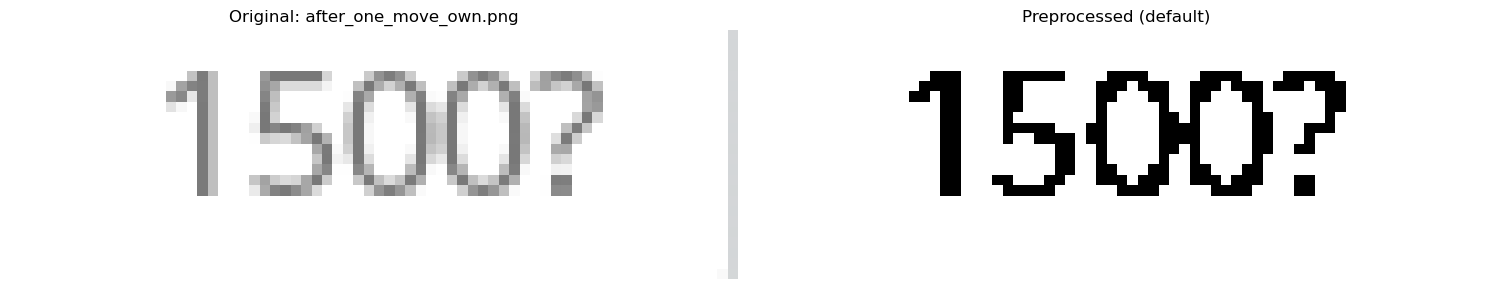


📄 Extracted Text from after_one_move_own.png:
1500?

📊 Metadata:
  Average Confidence: 93.0%
  Total Words: 1
  High Confidence Words (>70%): 1
  Preprocessing: default

🔍 Processing: before_any_move_own.png
------------------------------


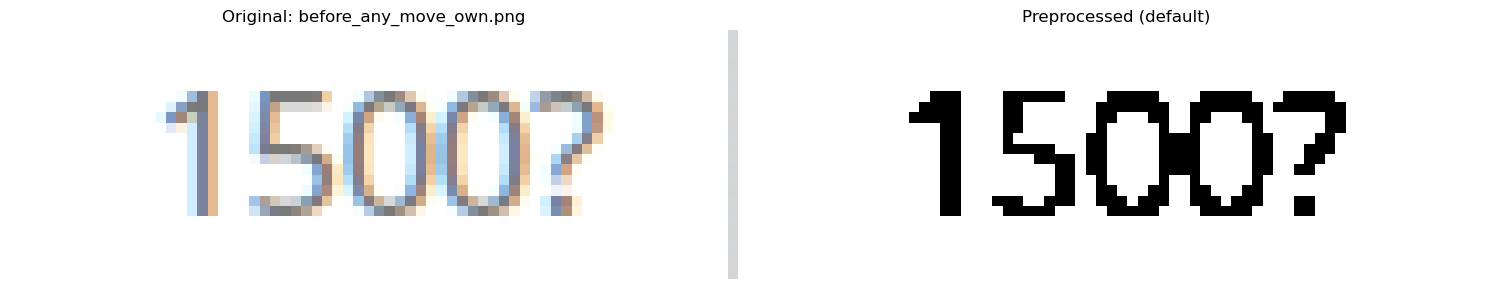


📄 Extracted Text from before_any_move_own.png:
1500?

📊 Metadata:
  Average Confidence: 86.0%
  Total Words: 1
  High Confidence Words (>70%): 1
  Preprocessing: default

🔍 Processing: start_opp_aborted.png
------------------------------


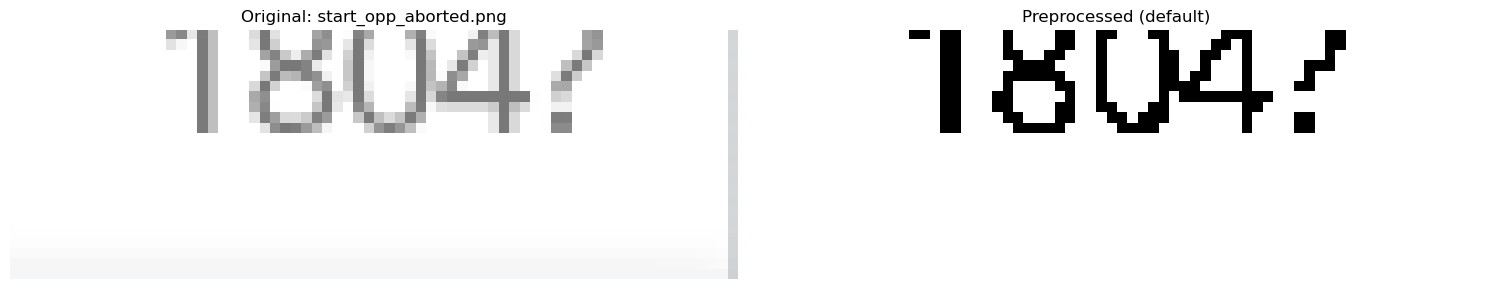


📄 Extracted Text from start_opp_aborted.png:
TOuer

📊 Metadata:
  Average Confidence: 0.0%
  Total Words: 1
  High Confidence Words (>70%): 0
  Preprocessing: default

🔍 Processing: start_opp_incorrect.png
------------------------------


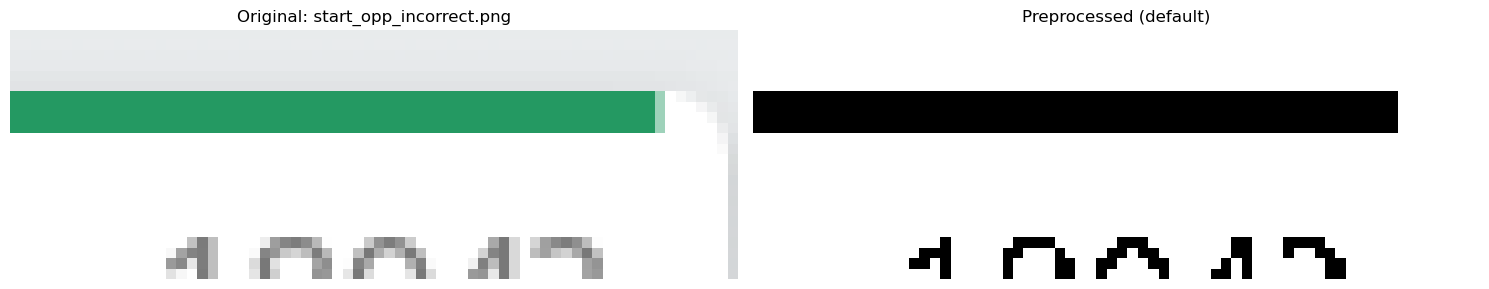


📄 Extracted Text from start_opp_incorrect.png:
_—

📊 Metadata:
  Average Confidence: 3.0%
  Total Words: 1
  High Confidence Words (>70%): 0
  Preprocessing: default

🔍 Processing: start_own_aborted.png
------------------------------


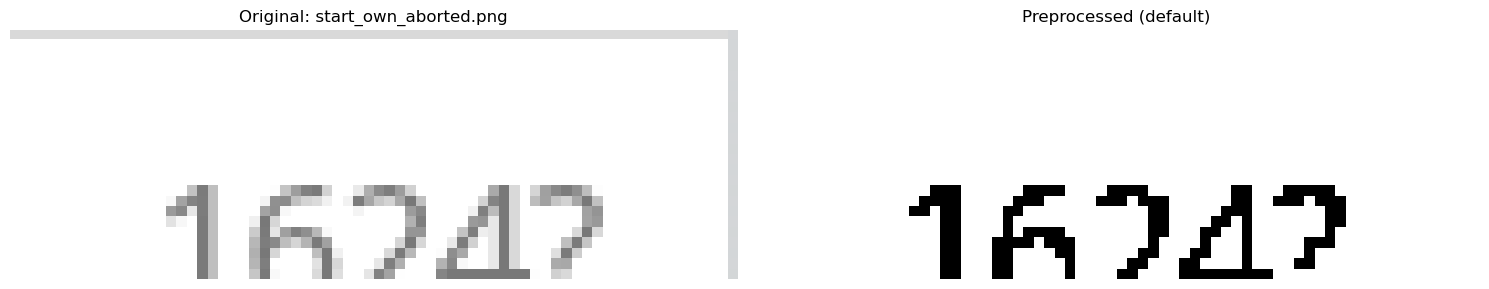


📄 Extracted Text from start_own_aborted.png:
46949

📊 Metadata:
  Average Confidence: 47.0%
  Total Words: 1
  High Confidence Words (>70%): 0
  Preprocessing: default

🔍 Processing: start_own_incorrect.png
------------------------------


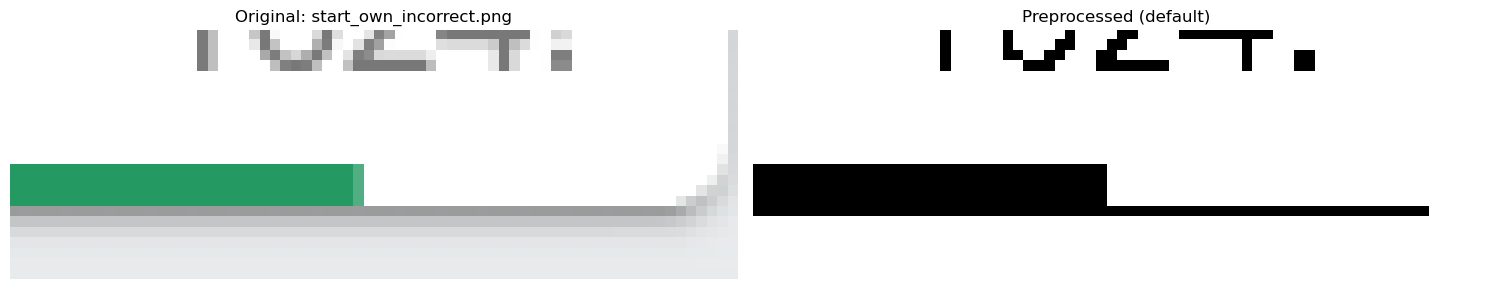


📄 Extracted Text from start_own_incorrect.png:
oe

📊 Metadata:
  Average Confidence: 26.0%
  Total Words: 1
  High Confidence Words (>70%): 0
  Preprocessing: default

✅ Completed processing 6 image(s)


In [17]:
# ===== PROCESS IMAGES =====
results = []

for image_filename in images_to_process:
    print(f"\n🔍 Processing: {image_filename}")
    print("-" * 30)
    
    # Extract text from the image
    result = extract_text_from_image(
        image_filename, 
        preprocess_type=preprocessing_type,
        custom_config=custom_tesseract_config
    )
    
    results.append(result)
    
    # Display the image and results
    display_image_and_text(image_filename, result, show_preprocessed=True)

print(f"\n✅ Completed processing {len(results)} image(s)")


In [9]:
# ===== SUMMARY =====
import pandas as pd

# Create a summary dataframe
summary_data = []
for result in results:
    if "error" not in result:
        summary_data.append({
            "Filename": result["filename"],
            "Text Length": len(result["text"]),
            "Avg Confidence": f"{result['average_confidence']:.1f}%",
            "Total Words": result["total_words"],
            "High Confidence Words": result["high_confidence_words"],
            "Has Text": "Yes" if result["text"].strip() else "No"
        })
    else:
        summary_data.append({
            "Filename": result["filename"],
            "Text Length": 0,
            "Avg Confidence": "Error",
            "Total Words": 0,
            "High Confidence Words": 0,
            "Has Text": "Error"
        })

if summary_data:
    summary_df = pd.DataFrame(summary_data)
    print("📊 Processing Summary:")
    print(summary_df.to_string(index=False))
else:
    print("No results to summarise.")


📊 Processing Summary:
               Filename  Text Length Avg Confidence  Total Words  High Confidence Words Has Text
 after_one_move_own.png            5          93.0%            1                      1      Yes
before_any_move_own.png            5          86.0%            1                      1      Yes
  start_opp_aborted.png            5           0.0%            1                      0      Yes
start_opp_incorrect.png            0           0.0%            0                      0       No
  start_own_aborted.png            5          47.0%            1                      0      Yes
start_own_incorrect.png            0           0.0%            0                      0       No


In [10]:
# ===== UTILITY: COMPARE PREPROCESSING METHODS =====
def compare_preprocessing_methods(image_filename):
    """
    Compare different preprocessing methods on the same image
    """
    if image_filename not in available_images:
        print(f"Image {image_filename} not found. Available images: {available_images}")
        return
    
    preprocessing_methods = ["none", "default", "enhanced"]
    
    print(f"🔬 Comparing preprocessing methods for: {image_filename}")
    print("=" * 60)
    
    for method in preprocessing_methods:
        print(f"\n--- {method.upper()} PREPROCESSING ---")
        result = extract_text_from_image(image_filename, preprocess_type=method)
        
        if "error" not in result:
            print(f"Text: {result['text'][:100]}{'...' if len(result['text']) > 100 else ''}")
            print(f"Confidence: {result['average_confidence']:.1f}%")
            print(f"Words: {result['total_words']}")
        else:
            print(f"Error: {result['error']}")

# Example usage (uncomment to test):
# compare_preprocessing_methods("after_one_move_own.png")
